# CSCI 4580|5580: Data Science
## Lab 7: Logistic Regression, AUC and Random Forests

#### Full name: Sharvita Paithankar
#### Student ID: 108172438

Given enough data, Logisitic Regression should always do at least as well as Naive Bayes on binary-feature data. Let's try that out on the text dataset (named <b>words</b>) that can be downloaded from Canvas under Lab 7. Place it in the same directory as this notebook and unzip it.

We'll also need the <b>MNIST</b> data from the last lab (Lab 6, but also available under Lab 7). Download it from Canvas and put it under the same directory as this notebook and unzip it.

First, load the text data:

In [7]:
import numpy as np
import scipy.sparse as sp
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

iwords = np.loadtxt("words.imat.txt")          # training data matrix in nnz x 3 form - rows are (doc, word, count) triples
traincats = np.loadtxt("cats.imat.txt")        # training labels in an ntrain x ncats matrix
tiwords = np.loadtxt("testwords.imat.txt")     # test data matrix in nnz x 3 form
testcats = np.loadtxt("testcats.imat.txt")     # test labels

The data come as dense matrices with (row, col, val) triples in their rows. But they represent sparse matrices so we do the conversion next. Note that the matrix constructor uses wordcount>0 tests instead of the actual word counts which has the effect of making the word features binary. 

In [8]:
train = sp.csr_matrix((iwords[:,2].astype("int") > 0, (iwords[:,1].astype("int"), iwords[:,0].astype("int"))))
ntrain = train.shape[0]
nfeats = train.shape[1]

test = sp.csr_matrix((tiwords[:,2] > 0, (tiwords[:,1], tiwords[:,0])),shape=(4000,nfeats))  # need to match the number of cols (words)
ntdocs = test.shape[0]

Once again we will concentrate on one label category, Category 6.

In [9]:
traincat6 = traincats[:,6]
testcat6 = testcats[:,6]

Now we'll import a Logistic Regression Classifier

In [15]:
from sklearn.linear_model import LogisticRegression
lrclassifier = LogisticRegression(max_iter=1000000)

and train it on the data:

In [16]:
lrclassifier.fit(train,traincat6)

LogisticRegression(max_iter=1000000)

In [17]:
preds = lrclassifier.predict(test)

> Q1: compute the accuracy of the predictions below:

In [18]:
# TODO: add code to score here (hint: this can be done in a single line of code)
accuracy = np.mean(preds == testcat6);
accuracy

0.91025

> Q2: How does this compare with Naive Bayes? In case you don't have the results handy, lets do it here:

[BernoulliNB docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)

In [19]:
from sklearn.naive_bayes import BernoulliNB
# TODO: add code to train, predict, score here (see sklearn documentation above for more info)
nbclassifier = BernoulliNB()
nbclassifier.fit(train,traincat6)
preds = nbclassifier.predict(test)
np.mean(preds == testcat6)

0.756

## Beyond Accuracy: ROC and AUC

Label prediction accuracy is a useful but sometimes misleading measure. E.g., for data with 10% positives, a predictor that always says "no" will be 90% accurate. It is also very often useful to control the ratio of positive/negative labels to minimize a loss function. E.g., false positives are generally more acceptable in computational marketing (it means you show an ad to someone who might not be interested) than false negatives (you failed to show an ad to someone who might be interest, and might generate some revenue for you). 

Logistic Regression computes the probability of a label and that output is useful for both richer evaluation methods, and for making more careful tradeoffs between positives and negatives. 

The ROC (Receiver-Operator Characteristic) curve is a very useful tool for interpreting classifier performance. See the background material here:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic .
It shows the classifiers TPR (True-Positive Rate) vs FPR (False-Positive Rate) at various thresholds. The threshold isnt shown on the plot but can be inferred later. TPR and FPR are defined as:

* TPR = TP / (TP + FN)   # based only on actual positive instances
* FPR = FP / (FP + TN)   # based only on actual negative instances

where TP = true positive, FN = false negative (actually a positive which is mislabelled), etc. 
Neither quantity involves a mix of positives and negatives. So ROC curves are insensitive to the actual ratio of positives to negatives. 

To use ROC, we first use a modified version of the ".predict" method which returns label probabilities:

In [22]:
preds = lrclassifier.predict_proba(test);
preds.shape

(4000, 2)

From which you can see that there are 2 columns, i.e., one probability of false and one for true. Verify that the sum of every row is 1:

In [23]:
np.sum(preds,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

We want the probabilities of cat6 membership = true, which is column 1:

In [24]:
preds6 = preds[:,1]

and we'll do a ROC plot for it. ROC plots represent the performance of a classifier over a range of possible threshold values, showing the true positive rate and false positives rates at those thresholds. In Python, do

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
rc = roc_curve(testcat6, preds6)

This function returns the X and Y coordinates of the ROC plot. To see it, do:

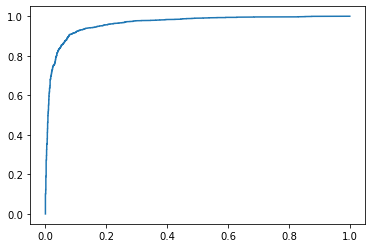

In [26]:
plt.plot(rc[0],rc[1])

> Q3: What is the True positive rate at an FPR of 0.2 ? 

In [20]:
# TODO: your response here
#According to the graph, the positive rate is around 0.95

Finally, the ROC curve is sometimes too much information, especially if you want to compare performance of many classifiers or datasets. The overall performance is well-characterized by the AUC or Area Under the Curve. Which is exactly what the name suggests, the area under the blue curve. Since a ROC plot lies in a 1 x 1 square, the area is always <= 1.0. A random predictor puts positives and negatives on a diagonal line with slope = 1, and so a random predictor has AUC = 0.5

Lets check the AUC for our prediction:

In [27]:
roc_auc_score(testcat6, preds6)

0.9637764912304416

## Critical Thinking: Interpreting AUC scores

The AUC score varies between 0.5 (random prediction) and 1.0. A common misconception is that a "perfect" predictor, i.e. a predictor that knows the exact probability of a label, will give a score of 1.0. That's incorrect. There are two sources of noise in the generation of a ROC plot:
* The difference between the true and predicted probability of a label
* The variance introduced by Bernoulli sampling to generate the label

The latter is always present and depends on the distribution of label probabilities, the former depends on how good the model is. 

To see this, imagine a binary label distribution where each data label has a true probability of 0.5. A perfect predictor knows these probabilities but since they all the same, the sorted labels for the ROC plot would still be a random distribution of true and false. The ROC plot would have an AUC of 0.5. AUC scores very close to 1 are possible, but require that the true label distribution include a large fraction of probabilities close to either 1 or 0. That's because the variance of a Bernoulli variable is p(1-p), which is small if p is near 0 or 1. 

Let's estimate the ROC AUC for a perfect predictor on a similar distribution to our dataset. We can't know this distribution, but we can use the model's prediction  as an approximation to it. 

First we'll generate some uniform random numbers in [0,1], one for each test point. 

In [28]:
a = npr.random(testcat6.shape)

Next we'll generate Bernoulli random numbers using the predictions as the underlying probability. We use the random numbers we just generated to do that. i.e. to generate a random Bernoulli variable with probability p, you generate a uniform random variable in [0,1] and test if (u < p). The probability that this test succeeds is exactly p. 

In [29]:
x = (a < preds6)

In [31]:
roc_auc_score(x, preds6)

0.9860854413384019

Compare this number with the AUC you computed earlier. To be clear again what this number is, it is the score of a *perfect* label predictor with the label probability distribution that our classifier has. It is an estimate of how well our classifier could do on this dataset. 

This secondary AUC calculation is a useful normalizing test when interpreting AUC scores. A common mistake is to assume that a model with AUC 0.85 on dataset A is better (i.e. would score higher on a common dataset) than a model with a score of 0.70 on dataset B. This is not true. It depends strongly on the dataset. The model with score 0.70 may be generating perfect or near-perfect predictions. 

(array([1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 2.00e+00, 3.00e+00,
        0.00e+00, 0.00e+00, 2.00e+00, 1.00e+00, 2.00e+00, 3.00e+00,
        0.00e+00, 3.00e+00, 1.00e+00, 2.00e+00, 5.00e+00, 1.00e+01,
        8.00e+00, 6.00e+00, 9.00e+00, 5.00e+00, 1.10e+01, 1.00e+01,
        8.00e+00, 2.60e+01, 2.50e+01, 2.00e+01, 2.60e+01, 3.20e+01,
        3.30e+01, 4.80e+01, 4.10e+01, 6.00e+01, 6.60e+01, 7.00e+01,
        6.90e+01, 9.60e+01, 1.08e+02, 1.19e+02, 1.04e+02, 1.27e+02,
        1.38e+02, 1.42e+02, 1.22e+02, 1.31e+02, 1.14e+02, 1.27e+02,
        1.52e+02, 1.91e+03]),
 array([-1.11982006e+01, -1.09742366e+01, -1.07502726e+01, -1.05263086e+01,
        -1.03023446e+01, -1.00783806e+01, -9.85441654e+00, -9.63045253e+00,
        -9.40648852e+00, -9.18252451e+00, -8.95856049e+00, -8.73459648e+00,
        -8.51063247e+00, -8.28666846e+00, -8.06270444e+00, -7.83874043e+00,
        -7.61477642e+00, -7.39081241e+00, -7.16684839e+00, -6.94288438e+00,
        -6.71892037e+00, -6.49495636e+00, -6.2

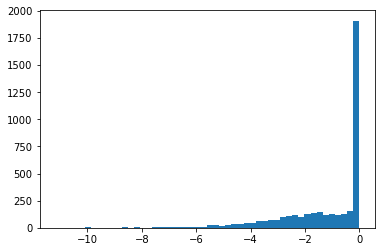

In [32]:
plt.hist(np.log10(preds6),50)

Which is an enormous range of values. Most probabilities are very close to zero or one, which is why this dataset has such a high ROC AUC score.

Suppose instead we had a dataset with a less wide distribution. We can use a lognormal distribution to simulate this for us:

In [33]:
cprob = np.minimum(npr.lognormal(-4,1,10000),1.0)

This is a pretty good model, e.g. for the range of user's probabilities of clicking on an ad. Let's look at a histogram of the log10 of the values (a direct histogram will be too squashed near 1). 

(array([   3.,    5.,   14.,   33.,   87.,  198.,  391.,  701., 1075.,
        1338., 1436., 1532., 1203.,  896.,  591.,  270.,  138.,   57.,
          25.,    7.]),
 array([-3.51156332, -3.3466016 , -3.18163988, -3.01667816, -2.85171643,
        -2.68675471, -2.52179299, -2.35683127, -2.19186955, -2.02690782,
        -1.8619461 , -1.69698438, -1.53202266, -1.36706093, -1.20209921,
        -1.03713749, -0.87217577, -0.70721405, -0.54225232, -0.3772906 ,
        -0.21232888]),
 <a list of 20 Patch objects>)

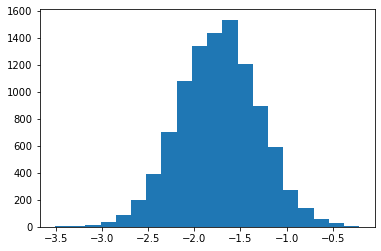

In [34]:
plt.hist(np.log10(cprob),20)

So that's our distribution of virtual users. Notice that the values (which represent click probabilities) range over several orders of magnitude since we plotted their log10. Next we simulate users' click behavior. Once again we generate a uniform random variable u for each user, and output 1 if u < the user's click probability given by cprob. 

Finally we compute the AUC on that data, which is the score of a perfect predictor on this data.

In [38]:
a = npr.random(cprob.shape)
x = (a < cprob)
roc_auc_score(x, cprob)

0.7478231220516866

So that's the AUC score for a perfect predictor on this (artificial) dataset. This is lower than the *real* predictions on the RCV1 text dataset. So be careful when interpreting AUC scores. There is no absolute scale for them, and they depend a lot on the dataset.

Another important point is that the AUC value for mid-range scores can have quite a lot of variance. Try re-evaluating the last cell to see what happens. 

> Q4: What changes do you think you should make to the distribution cprob to increase the ROC AUC score?
>Instead of inspecting numerous confusion matrices, we can try to figure out the best threashold. Sicne it is better to automatically calculate TP and FP rates at the threshold and visualize all results along a ROC curve. From this, we can also concldue which threasholds give us the best accuracy.
If we different threashold values, the distibution of cprob to increase the ROC AUC score. 
which threashold might give us the best accuracy.If you had a distribution with less 0's it woudl perfom better.

## Random Forests

Random Forests are an extremely accurate classifier for datasets of moderate size. Let's try them out here. We'll load the MNIST data now, but first its probably a good idea to restart your kernel to reduce memory use. Click on the "Kernel" menu above and then "Restart". 

In [1]:
import numpy as np
import scipy.sparse as sp
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train0=np.loadtxt("train.fmat.txt")
test0=np.loadtxt("test.fmat.txt")
train = np.transpose(train0[:,0:4000])
test = np.transpose(test0[:,0:2000])
traincats = np.loadtxt("ictrain.imat.txt")
testcats = np.loadtxt("ictest.imat.txt")

Because we're going to tuning the parameters of RFs on some test data, we need to split our test set into a validation set and a final test set to avoid overfitting:

In [3]:
validation = test[0:1000,:]
finaltest = test[1000:2000,:]
validationcats = testcats[0:1000]
finaltestcats = testcats[1000:2000]

In [4]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier(criterion='gini',max_features=30,n_estimators=20,n_jobs=4,bootstrap=True)
rfclassifier

RandomForestClassifier(max_features=30, n_estimators=20, n_jobs=4)

In [5]:
rfclassifier.fit(train,traincats)
preds = rfclassifier.predict(validation)
np.mean(preds == validationcats)

0.883

Read the [scikit-learn documentation for Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier) to make sure you understand the meaning of all the parameters in the call to the RandForestClassifier constructor. Which ones do you think will improve accuracy the most? **NOTE** you don't need to tune n_jobs. Its the number of threads that the classifier code runs and it only affects running time. It should be set to the number of cores that your processor has. 

Try tuning the classifier with the validation set above to get better than 90% accuracy on the validation set. Don't touch the final test set until you're done tuning. 

> Q5: Make a table with at least two values you tried each for criterion, max_features, n_estimators, and bootstrap. What trends to you notice for each one? 

> Q6: Report your validation and final test accuracy. Include all the parameters you used, e.g., include the line where you invoked the RandomForestClassifier constructor. 

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier(criterion='entropy',max_features=40,n_estimators=80,n_jobs=4,bootstrap=True)
rfclassifier
rfclassifier.fit(train,traincats)
preds = rfclassifier.predict(validation)
np.mean(preds == validationcats)



0.914

In [28]:
# TODO: code and response for Q5 here

from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier(criterion='gini',max_features=30,n_estimators=40,n_jobs=4,bootstrap=False)
rfclassifier
rfclassifier.fit(train,traincats)
preds = rfclassifier.predict(validation)
np.mean(preds == validationcats)

0.926

| Accuracy     | 0.914   | 0.926 |
|--------------|---------|-------|
| criterion    | entropy | gini  |
| max_features | 40      | 30    |
| n_estimators | 80      | 40    |
| bootstrap.   | True    | False |


I noticed that when the bootstrap is false, the accuracy is higher.
Also if the number are the same for max_features and n_estimators while bootstrap is true, the accuracy is higher 

In [35]:
# TODO: response/code for Q6 here (either a written response or reporting with code are fine)

rfclassifier = RandomForestClassifier(criterion='gini',max_features=30,n_estimators=40,n_jobs=4,bootstrap=False)
rfclassifier
rfclassifier.fit(train,traincats)

RandomForestClassifier(bootstrap=False, max_features=30, n_estimators=40,
                       n_jobs=4)

In [34]:
preds = rfclassifier.predict(finaltest)
np.mean(preds == finaltestcats)


0.895

> Q7: Reflect on and explain any differences between your validation and final test accuracy scores. 

At first I tried different numbers for max_features and n_estimators, figured out which ones give me the best accuracy. After trying a lot of numbers, I changed the criterion and the bootstrap to see if that made any difference. The code with where bootstrap is false, has a higher accuracy than one where it is true. It seems to me that the criterion did not make much of a difference. 



## Submit Your Responses

Submit this notebook on Canvas under Lab 7 by Friday, November 6th at 11:59PM.